# CNN to classify cats/dogs

In [1]:
import matplotlib.pyplot as plt
import os
import random

# The Cats and Dogs dataset

Taking a look at the data:

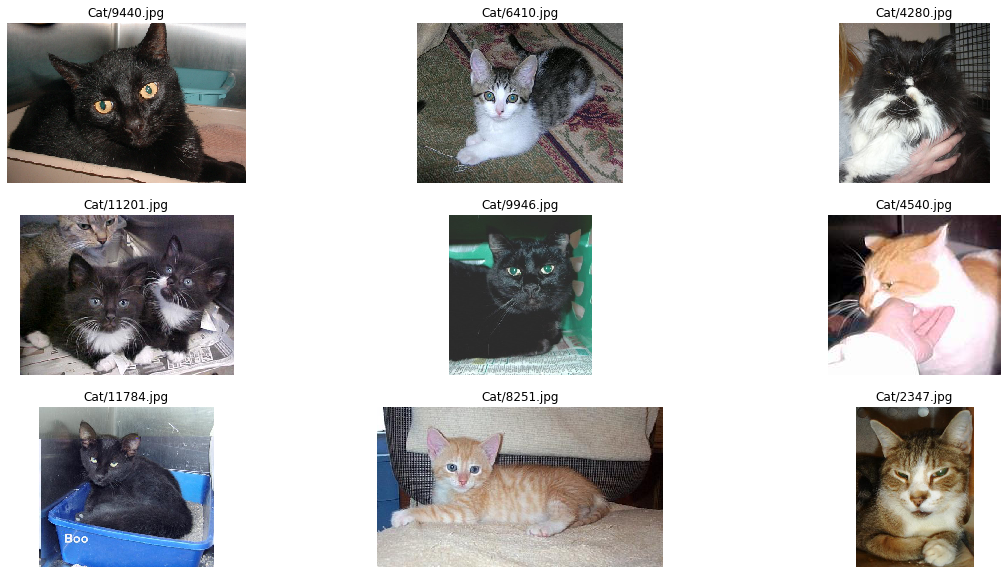

In [2]:
src = 'Dataset/PetImages/'

# Get list of file names
_, _,cat_images = next(os.walk('Dataset/PetImages/Cat'))

# Prepare a 3x3 plot (total of 9 images)
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('Dataset/PetImages/Cat/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)

plt.show()

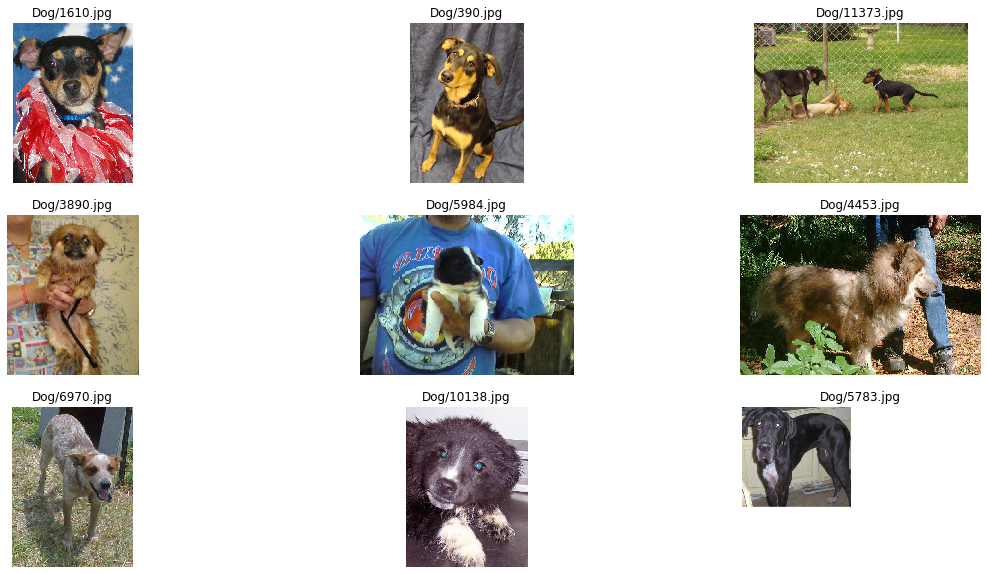

In [3]:
# Get list of file names
_, _, dog_images = next(os.walk('Dataset/PetImages/Dog'))

# Prepare a 3x3 plot (total of 9 images)
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('Dataset/PetImages/Dog/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/'+img)

plt.show()

Some observations from the data:
    - The images have different dimensions
    - The subjects are mostly centered in the image
    - The subjects have different orientations

## Train/test split

Here I am splitting the data into train/test folders for each class: cat/dog:

In [9]:
from utils import train_test_split

src_folder = 'Dataset/PetImages/'
train_test_split(src_folder)

## Image augmentation